<a href="https://colab.research.google.com/github/3D-Generation-Project-Kmitl/3d-model-generation/blob/main/Copy_of_Mask_RCNN_Depth_Map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/leekunhee/Mask_RCNN.git
%cd Mask_RCNN

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.
/content/Mask_RCNN/Mask_RCNN


First do small changes to the model

In [ ]:
%cd mrcnn/
!wget -q -O - "https://gist.githubusercontent.com/wathek/256e8a53263b418fe40c0f3f0127c8e6/raw/64f91cdb5b4ae1b82b4725f5f48a4c16830c6fa2/model.patch" | patch -u model.py -i -

/content/Mask_RCNN/Mask_RCNN/mrcnn
patching file model.py
Reversed (or previously applied) patch detected!  Assume -R? [n] 
Apply anyway? [n] 
Skipping patch.
20 out of 20 hunks ignored -- saving rejects to file model.py.rej


# Mask R-CNN Demo and TFLite Conversion

A quick intro to using the pre-trained model to detect and segment objects.

In [ ]:
%cd /content/Mask_RCNN/

/content/Mask_RCNN


In [ ]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco
    
%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")
DEPTH_DIR=os.path.join(ROOT_DIR, "depth")

ModuleNotFoundError: ignored

In [ ]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Create Model and Load Trained Weights

In [ ]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

In [ ]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Run Object Detection

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  218.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:   97.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


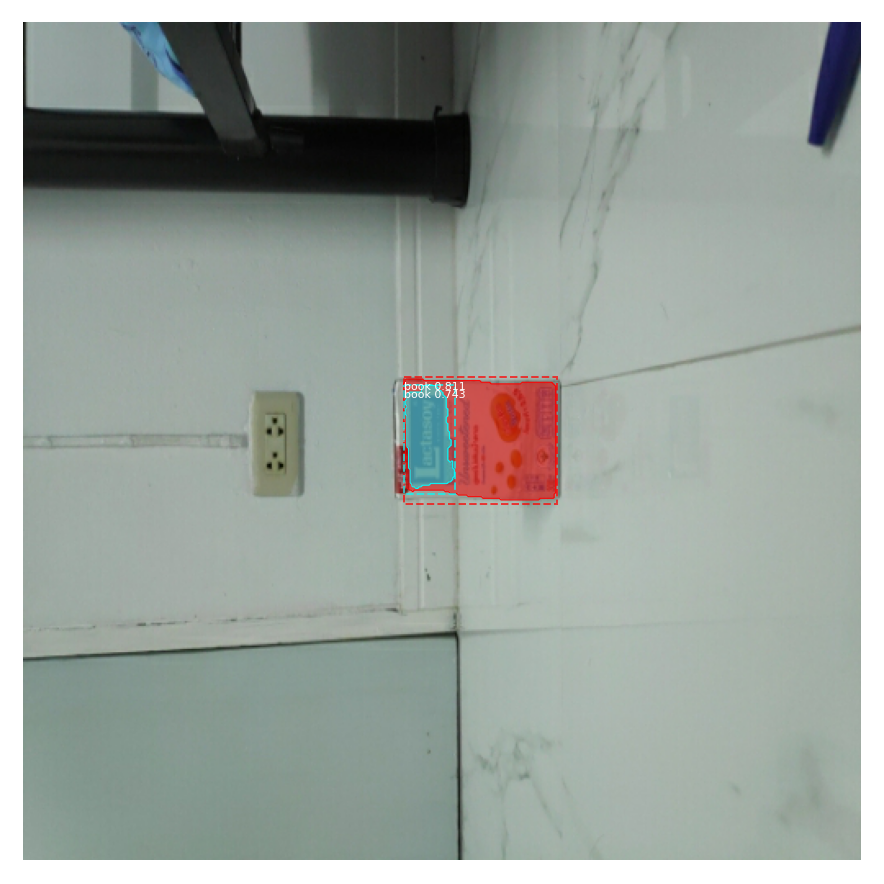

In [ ]:
# Load a random image from the images folder
# file_names = next(os.walk(IMAGE_DIR))[2]
# image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
cameraFile = "camera_45.jpg"
depthFile="depthData_45.txt"
image = skimage.io.imread(os.path.join(DEPTH_DIR, cameraFile))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

In [ ]:
r 

{'class_ids': array([74, 74], dtype=int32), 'masks': array([[[False, False],
         [False, False],
         [False, False],
         ...,
         [False, False],
         [False, False],
         [False, False]],
 
        [[False, False],
         [False, False],
         [False, False],
         ...,
         [False, False],
         [False, False],
         [False, False]],
 
        [[False, False],
         [False, False],
         [False, False],
         ...,
         [False, False],
         [False, False],
         [False, False]],
 
        ...,
 
        [[False, False],
         [False, False],
         [False, False],
         ...,
         [False, False],
         [False, False],
         [False, False]],
 
        [[False, False],
         [False, False],
         [False, False],
         ...,
         [False, False],
         [False, False],
         [False, False]],
 
        [[False, False],
         [False, False],
         [False, False],
         ...,
         

In [ ]:
class_names[74]

'book'

In [ ]:
target=r['masks'][:,  :,0]

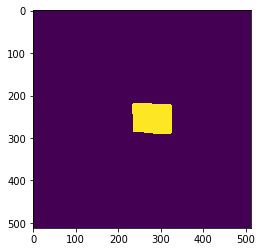

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(target , interpolation='nearest')
plt.show()

In [ ]:
target=np.rot90(target, -1)
target.shape

(512, 512)

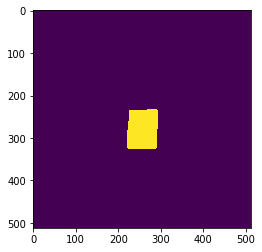

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(target , interpolation='nearest')
plt.show()

In [ ]:
from skimage.transform import resize
target = resize(target, (160, 90))

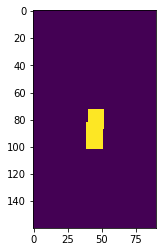

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(target , interpolation='nearest')
plt.show()

In [ ]:
results=np.where(target== True)
len(results[0])
len(results[1])

353

In [ ]:
(max(results[1])-min(results[1]))/2

6.0

In [ ]:
results=np.where(target== True)
max_size=len(results[0])


In [ ]:
import numpy as np
import cv2 as cv
import os

In [ ]:
# depthData = np.fromfile(os.path.join(DEPTH_DIR,"rawDepthData.txt"), dtype = np.uint16)
depthData = np.fromfile("rawDepthData.txt", dtype = np.uint16)
W = 160
H = 90
def extractDepth(x):
    return x & 0x1FFF 
depthMap = np.array([extractDepth(x) for x in depthData]).reshape(H,W)
depthMap = cv.rotate(depthMap, cv.ROTATE_90_CLOCKWISE)

ValueError: ignored

In [ ]:
depthMap.shape

(160, 90)

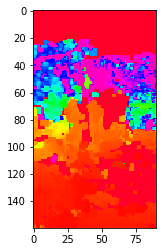

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(depthMap , interpolation='nearest',cmap="gist_rainbow")
plt.show()

In [ ]:
depth_masked=np.zeros((max_size,max_size))

In [ ]:
x=results[1]
y=results[0]

In [ ]:
results

(array([ 73,  73,  73,  73,  73,  73,  73,  73,  73,  73,  73,  73,  74,
         74,  74,  74,  74,  74,  74,  74,  74,  74,  74,  74,  75,  75,
         75,  75,  75,  75,  75,  75,  75,  75,  75,  75,  76,  76,  76,
         76,  76,  76,  76,  76,  76,  76,  76,  76,  77,  77,  77,  77,
         77,  77,  77,  77,  77,  77,  77,  77,  78,  78,  78,  78,  78,
         78,  78,  78,  78,  78,  78,  78,  79,  79,  79,  79,  79,  79,
         79,  79,  79,  79,  79,  79,  80,  80,  80,  80,  80,  80,  80,
         80,  80,  80,  80,  80,  81,  81,  81,  81,  81,  81,  81,  81,
         81,  81,  81,  81,  82,  82,  82,  82,  82,  82,  82,  82,  82,
         82,  82,  82,  82,  83,  83,  83,  83,  83,  83,  83,  83,  83,
         83,  83,  83,  83,  84,  84,  84,  84,  84,  84,  84,  84,  84,
         84,  84,  84,  84,  85,  85,  85,  85,  85,  85,  85,  85,  85,
         85,  85,  85,  85,  86,  86,  86,  86,  86,  86,  86,  86,  86,
         86,  86,  86,  86,  87,  87,  87,  87,  87

In [ ]:
depthMap.shape

(160, 90)

In [ ]:
middle=int(max_size/2)

In [ ]:
depth_masked=np.zeros((max_size))
for i in range(max_size):
    depth_masked[i]=depthMap[y[i]][x[i]]/10
depth_masked


array([ 99.6,  99.7,  99.7,  99.7, 100. , 100.5, 100.4, 100.1,  99.8,
        99.6,  99.6,  99.5,  99.7, 100. , 100. , 100. , 100. , 100.6,
       100.2,  99.8,  99.5,  99.4,  99.4,  99.3,  99.9,  99.9, 100.3,
       100.4, 100.9, 100.5, 100. ,  99.6,  99.4,  99.2,  99.2,  99.2,
       100. , 100.1, 100.1, 101.1, 100.9, 100.5, 100. ,  99.6,  99.3,
        99.1,  99.1,  99.1,  99.8, 100.2, 100.3,  99.5, 100.7, 100.4,
       100. ,  99.6,  99.4,  99.2,  99.1,  99.2,  99.6, 100. ,  99.7,
        99.8, 100.3, 100.3, 100. ,  99.8,  99.6,  99.4,  99.5,  99.5,
        99.5,  99.6, 100. , 100.1, 100.4, 100.3, 100.1, 100. ,  99.9,
        99.8,  99.8, 100. ,  99.2,  99.3, 100.1, 100.3, 100.5, 100.4,
       100.3, 100.3, 100.3, 100.3, 100.4, 100.6,  99.5,  99.6, 100.5,
       100.8, 100.9, 100.8, 100.9, 100.7, 100.7, 100.9, 101.1, 101.3,
       101.4, 101.1, 101.1, 101.5, 102. , 101.8, 101.5, 102.7, 101.4,
       100.8, 101.4, 101.8, 102.1, 102.5, 102.1, 102.1, 102.2, 102.4,
       102.6, 102.3,

In [ ]:
import pandas as pd
import numpy as np

df_describe = pd.DataFrame(depth_masked)
df_describe.describe()

,0
count,353.000000
mean,97.608499
std,13.712649
min,51.100000
25%,99.600000
50%,101.100000
75%,104.100000
max,111.500000
